In [15]:
import numpy as np
# Enable interactive mode
#%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from skimage.io import imread
import re
import os

# ImageJ data

Using data extracted to a .csv file from ImageJ with the scale already set.

In [16]:
data = pd.read_csv('silicone oil ref wafer.csv', encoding='ISO-8859-1')    
df = gaussian_filter1d(data['Gray_Value'], sigma=15)

peaks1, _ = find_peaks(data['Gray_Value'], prominence=7, width=2)
peaks2, _ = find_peaks(-1*data['Gray_Value'], prominence=7, width=2)

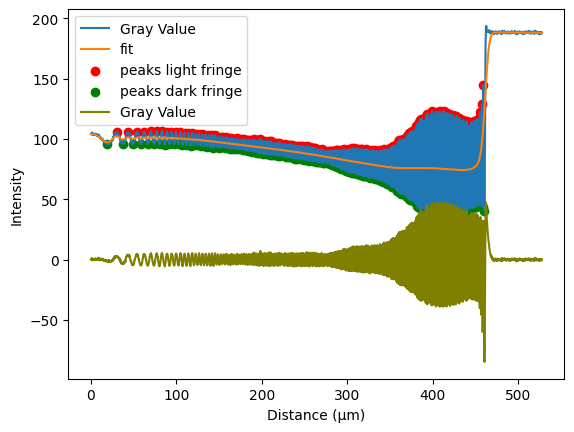

In [17]:
plt.figure()
plt.plot(data['Distance_(µm)'], data['Gray_Value'], label='Gray Value')
plt.plot(data['Distance_(µm)'], df, label='fit')
plt.scatter(data['Distance_(µm)'][peaks1], data['Gray_Value'][peaks1], color='red', label='peaks light fringe')
plt.scatter(data['Distance_(µm)'][peaks2], data['Gray_Value'][peaks2], color='green', label='peaks dark fringe')
plt.plot(data['Distance_(µm)'], data['Gray_Value'] - df, label='Gray Value', color='olive')
plt.xlabel('Distance (µm)')
plt.ylabel('Intensity')
plt.legend()
plt.show()

# Equations
$\lambda = 475 nm$

$\Delta h = \dfrac{\lambda}{2 n} $ with $n = 1.4$ for this polymers. (https://www.sigmaaldrich.com/FR/fr/product/aldrich/378399)

Then we can calculate the height $h$ by finding the number of fringes there is from the position we want to calculate from the edge:
$h(i) = i \dfrac{\lambda}{2 n}$ with $i$ the numbers of fringes.

In [18]:
h = np.zeros(len(peaks2))
lmbda = 488/1000
# La LED est centrée sur 475nm, mais le filtre est à 488nm
n = 1.4
# indice 1.4 https://www.sigmaaldrich.com/FR/fr/product/aldrich/378399
for i in range(len(peaks2) - 2, -1, -1):
    h[i] = h[i+1] + lmbda/(2*n)
mid_idx = int(len(peaks2) / 1.2)

dh = h[mid_idx]
dd = data['Distance_(µm)'].iloc[peaks2].iloc[mid_idx]
dda = data['Distance_(µm)'].iloc[peaks2].iloc[-1] - data['Distance_(µm)'].iloc[peaks2].iloc[mid_idx]

angle = np.arctan2(dh, dda)
print('Angle in radians: ', angle)
angle_deg = np.degrees(angle)
print('Angle in degrees: ', angle_deg)

Angle in radians:  0.12182036837445329
Angle in degrees:  6.979792966585142


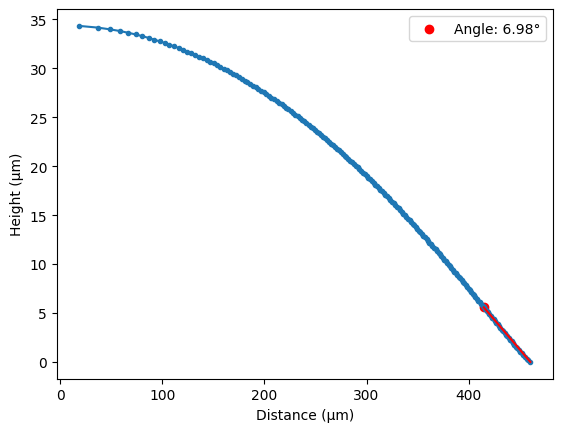

In [19]:
plt.figure()
plt.plot(data['Distance_(µm)'][peaks2], h, '.-')
plt.plot([dd, data['Distance_(µm)'].iloc[peaks2].iloc[-1]], [dh, h[-1]], color='red')
plt.scatter(dd, dh, color='red', label='Angle: %1.2f°' % angle_deg)
plt.xlabel('Distance (µm)')
plt.ylabel('Height (µm)')
plt.legend()
plt.show()

In [20]:
dd_vec = data['Distance_(µm)'].iloc[peaks2]
dda_vec = data['Distance_(µm)'].iloc[peaks2].iloc[-1] - data['Distance_(µm)'].iloc[peaks2]
angle_vec = np.arctan2(h, dda_vec)
angle_deg_vec = np.degrees(angle_vec)
fig, ax1 = plt.subplots()

ax1.plot(data['Distance_(µm)'][peaks2], h, '.-b')
ax1.set_xlabel('Distance (µm)')
ax1.set_ylabel('Height (µm)', color='blue')

ax2 = ax1.twinx()

ax2.plot(data['Distance_(µm)'][peaks2][:-1], angle_deg_vec[:-1], '.-r')
ax2.set_ylabel('Angle (°)', color='red')

fig.suptitle('Height vs Angle')
plt.show()

# Raw image data

This code imports the image directly and does the calculation automatically without having to use ImageJ.

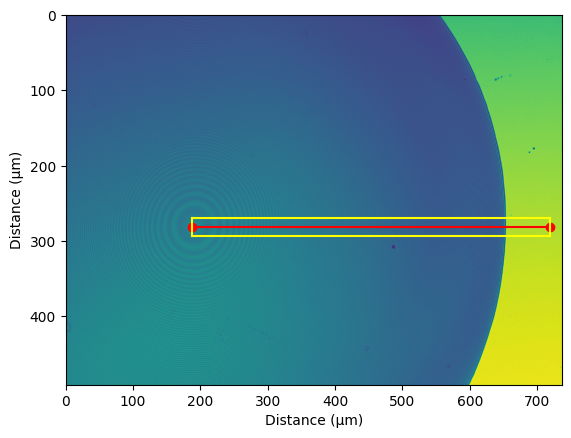

In [21]:
image = imread('Image 1_ch00.tif', as_gray=True)
fig, ax = plt.subplots()
width = 736.56
height = 490.96
c_width = 736.56 / np.shape(image)[1]
c_height = 490.96 / np.shape(image)[0]
x_dist = np.linspace(0, width, image.shape[1])
y_dist = np.linspace(0, height, image.shape[0])

cax = ax.imshow(image, extent=[0,width,height, 0], aspect="auto")
x1, y1, x2, y2 = 785, 1172, 3000, 1172 
l = 50

slice_rows = image[y1 -50:y2+50]
slice_cols = slice_rows[:, x1:x2]
average = np.mean(slice_cols, axis=0)
ax.plot([x_dist[x1], x_dist[x2]], [y_dist[y1], y_dist[y2]], '-o', color='red')
ax.plot([x_dist[x1], x_dist[x1]], [y_dist[y1-l], y_dist[y2+l]], color='yellow')
ax.plot([x_dist[x2], x_dist[x2]], [y_dist[y1-l], y_dist[y2+l]], color='yellow')
ax.plot([x_dist[x1], x_dist[x2]], [y_dist[y1+l], y_dist[y2+l]], color='yellow')
ax.plot([x_dist[x1], x_dist[x2]], [y_dist[y1-l], y_dist[y2-l]], color='yellow')

ax.set_xlabel('Distance (µm)')
ax.set_ylabel('Distance (µm)')

plt.show()

plt.figure()
plt.plot(x_dist[x1:x2], average)
plt.xlabel('Distance (µm)')
plt.ylabel('Intesity')
plt.show()
average_old = average
# pour reduire le bruit faire la moyenne sur plusieurs lignes. FAIT
# convertir pixels en µm  FAIT (à améliorer pour prendre en compte l'origine)
# trouver le volume de la goutte (calotte spherique) FAIT
# TODO: trouver l'origine de l'image a partir des données
# récupérer le temps des metadonnée et faire une évolution en fonction du temps FAIT 

In [22]:
df2 = gaussian_filter1d(average, sigma=15)

peaks3, _ = find_peaks(average, prominence=0.03, width=2)
peaks4, _ = find_peaks(-1*average, prominence=0.03, width=2)
def hf(peaks):
    h = np.zeros(len(peaks))
    lmbda = 488/1000
    # La LED est centrée sur 475nm, mais le filtre est à 488nm
    n = 1.4
    # indice 1.4 https://www.sigmaaldrich.com/FR/fr/product/aldrich/378399
    for i in range(len(peaks2) - 2, -1, -1):
        h[i] = h[i+1] + lmbda/(2*n)
    return h
reset_zero_ind = -x1
x_coord = np.linspace(0, x_dist[x2-x1-peaks4[0]], image.shape[1]-x1-peaks4[0]+15)
x_coord
len(average)
plt.figure()
plt.plot(x_coord[0:x2], average, label='Gray Value')
plt.plot(data['Distance_(µm)'], data['Gray_Value']/100, 'r', label='Gray Value ImageJ') # /100 for scale
plt.plot(x_coord[0:x2], df2, label='fit')
plt.scatter(x_coord[0:x2][peaks3], average[peaks3], color='red', label='peaks light fringe')
plt.scatter(x_coord[0:x2][peaks4], average[peaks4], color='green', label='peaks dark fringe')
plt.plot(x_coord[0:x2], average - df2, label='Gray Value', color='olive')
plt.xlabel('Distance (µm)')
plt.ylabel('Intensity')
plt.legend()

plt.show()

fig, ax1 = plt.subplots()

ax1.plot(x_coord[0:x2][peaks2], h, '.-b', label='imageJ')
ax1.plot(x_coord[0:x2][peaks4], hf(peaks4), '.-y', label='raw image')
ax1.set_xlabel('Distance (µm)')
ax1.set_ylabel('Height (µm)', color='blue')

ax2 = ax1.twinx()
dd_vec = data['Distance_(µm)'].iloc[peaks2]
dda_vec = data['Distance_(µm)'].iloc[peaks2].iloc[-1] - data['Distance_(µm)'].iloc[peaks2]

angle_vec = np.arctan2(h, dda_vec)
angle_deg_vec = np.degrees(angle_vec)
ax2.plot(x_coord[0:x2][peaks2][:-1], angle_deg_vec[:-1], '.-r', label='imageJ')

dd_vec = x_coord[0:x2][peaks4]
dda_vec = x_coord[0:x2][peaks4][-1] - x_coord[0:x2][peaks4]
angle_vec = np.arctan2(hf(peaks4), dda_vec)
angle_deg_vec = np.degrees(angle_vec)
ax2.plot(x_coord[0:x2][peaks4][:-1], angle_deg_vec[:-1], '.-g', label='raw image')
ax2.set_ylabel('Angle (°)', color='red')

fig.suptitle('Height vs Angle')
ax1.legend()
ax2.legend()
plt.show()

## Calculating the volume of the droplet

- The volume of a spherical cap is given by the formula:
$$V = \frac{1}{6} \cdot \pi \cdot h \cdot \left( 3r^2 + h^2 \right)$$

With $r$ the radius of the droplet and $h$ the height of the droplet at its center.

In [23]:
def spherical_cap_volume(r, h):
    return (1/6) * np.pi * h * (3*r**2 + h**2)

V = spherical_cap_volume(461.34, h[0])
print(f'Volume of the droplet: %1.2f' % (V), 'µm^3')
print(f'Volume of the droplet: %1.2f' % (V/1e9), 'µL^3')

Volume of the droplet: 11499824.09 µm^3
Volume of the droplet: 0.01 µL^3


In [24]:
with open('../24-06-10/silicon oil wafer 15min 1170C.rgn', 'r') as file:
    text = file.read()

# Use regular expression to extract ReferenceX and ReferenceY values
pattern = r"ReferenceX=\"([^\"]+)\"|ReferenceY=\"([^\"]+)\""
matches = re.findall(pattern, text)

# Extract X and Y values from matches
x_values = []
y_values = []
for match in matches:
    if match[0] != '':
        x_values.append(float(match[0])*1e6) # *1e6: conversion m -> µm
    elif match[1] != '':
        y_values.append(float(match[1])*1e6) # *1e6: conversion m -> µm

reference_coords = np.array((x_values, y_values)).T

print(reference_coords)
diff = x_values[0] - x_values[1]
print(diff)
x_shift = width - diff
x_shift

[[60520.8942 43052.6818]
 [60285.0661 43052.6818]
 [61331.3476 43052.6818]]
235.8281000000061


500.73189999999386

## Timelapse

### 24-06-06

In [25]:
folder_path = '../timelapse 24-06-06'

# Get all filenames in the directory, ignoring MetaData
filenames = [file for file in os.listdir(folder_path) if not file.startswith('MetaData')]

# Extract the last filename (to guess the total number of images)
last_filename = filenames[-1]

# Extract the number from the last filename (assuming this format: "Image X_tXX_ch00.tif")
total_images = int(last_filename.split('_')[1].split('.')[0][1:]) + 1
images = []
for file in filenames:
    # Extract the number from each filename
    image_number = int(file.split('_')[1].split('.')[0][1:])
    images.append(imread(os.path.join(folder_path, file), as_gray=True))

image_matrix = np.array(images)

print(image_matrix.shape)
with open(folder_path + '/MetaData/Series002_Properties.xml', 'r') as f:
    text = f.read()

# Use regular expression to find the length for X dimension
length_x = float(re.search(r'DimID="X".*?Length="([^"]*)"' , text).group(1))
length_y = float(re.search(r'DimID="Y".*?Length="([^"]*)"' , text).group(1))
t = float(re.search(r'DimID="T".*?Length="(\d+)m' , text).group(1))

x_dist = np.linspace(diff, width+diff, image_matrix.shape[2])
y_dist = np.linspace(0, length_y, image_matrix.shape[1])

y = int(image_matrix.shape[1]/2)
x = int(image_matrix.shape[2]/2.5)
average = []
for i in range(0, image_number+1):
    slice_rows = image_matrix[i][y-50:y+50]
    slice_cols = slice_rows[:, 0:x]
    average.append(np.mean(slice_cols, axis=0))
average = np.array(average)
df = []
peaks_bright = []
peaks_dark = []
for i in range(0, image_number+1):
    df.append(gaussian_filter1d(average[i], sigma=15))
    peaks_bright.append(find_peaks(average[i], prominence=0.007, width=1)[0])
    peaks_dark.append(find_peaks(-1*average[i], prominence=0.007, width=1)[0])
# La prominence du pic dimiue quand on se rapproche du centre, faire attention a bien trouver la bonne valeur

def hf(peaks):
    h = np.zeros(len(peaks))
    lmbda = 488/1000
    # La LED est centrée sur 475nm, mais le filtre est à 488nm

    n = 1.4
    # indice 1.4 https://www.sigmaaldrich.com/FR/fr/product/aldrich/378399
    for i in range(len(peaks) - 2, -1, -1):
        h[i] = h[i+1] + lmbda/(2*n)
    return h
dd_vec = []
dda_vec = []
angle_vec = []
angle_deg_vec = []
x_vec = []
for i in range(0, image_number+1):
    x_vec = np.arange(0, len(average[i]), 1)
    dd_vec.append(x_vec[peaks_dark[i]])
    dda_vec.append(x_vec[peaks_dark[i]][-1] - x_vec[peaks_dark[i]])
    angle_vec.append(np.arctan2(hf(peaks_dark[i]), dda_vec[i]))
    angle_deg_vec.append(np.degrees(angle_vec[i]))

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,image_number+1)))

fig, ax = plt.subplots()
for i in range(0, image_number+1):
    ax.plot(x_dist[0:x], average[i])
    #ax.plot(x_dist[0:x], df[i])
    #ax.scatter(x_dist[0:x][peaks_bright[i]], average[i][peaks_bright[i]], color='red', label='peaks light fringe')
    #ax.scatter(x_dist[0:x][peaks_dark[i]], average[i][peaks_dark[i]], color='green', label='peaks dark fringe')
plt.figure()
ax.plot(x_coord[0:x2], average_old, label='Gray Value')


fig, ax = plt.subplots()
for i in range(0, image_number+1):
    ax.plot(x_dist[peaks_dark[i]][0:-1], angle_deg_vec[i][0:-1], '.-')
dd_vec = x_coord[0:x2][peaks4]
dda_vec = x_coord[0:x2][peaks4][-1] - x_coord[0:x2][peaks4]
angle_vec = np.arctan2(hf(peaks4), dda_vec)
angle_deg_vec = np.degrees(angle_vec)
ax.plot(x_coord[0:x2][peaks4][:-1], angle_deg_vec[:-1], '.-g', label='raw image')

ax.set_xlabel('Distance (µm)')
ax.set_ylabel('Angle (°)')
ax.legend(title='Image Number', labels=[str(i) for i in range(image_number+1)])
plt.show()

fig, ax = plt.subplots()
ax.plot(x_coord[0:x2][peaks2], h, '.-b', label='imageJ')
for i in range(0, image_number+1):
    ax.plot(x_dist[peaks_dark[i]],hf(peaks_dark[i]), '.-')
ax.set_xlabel('Distance (µm)')
ax.set_ylabel('Height (µm)')
ax.legend(title='Image Number', labels=[str(i) for i in range(image_number+1)])
plt.show()

(13, 2048, 3072)


<Figure size 640x480 with 0 Axes>

### 24-06-07

(68, 2048, 3072)


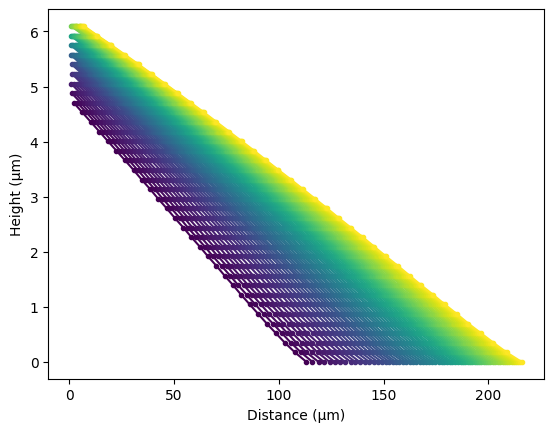

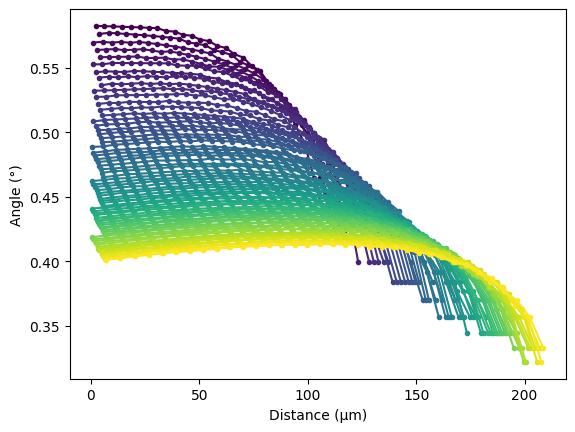

In [26]:
folder_path = '../timelapse 24-06-07'

# Get all filenames in your directory, ignoring MetaData
filenames = [file for file in os.listdir(folder_path) if not file.startswith('MetaData')]

# Extract the last filename (to guess the total number of images)
last_filename = filenames[-1]

# Extract the number from the last filename (assuming it is always in this format: "Image X_tXX_ch00.tif")
total_images = int(last_filename.split('_')[1].split('.')[0][1:]) + 1
images = []
for file in filenames:
    # Extract the number from each filename
    image_number = int(file.split('_')[1].split('.')[0][1:])
    images.append(imread(os.path.join(folder_path, file), as_gray=True))

image_matrix = np.array(images)

print(image_matrix.shape)
with open(folder_path + '/MetaData/Image 2_Properties.xml', 'r') as f:
    text = f.read()

# Use regular expression to find the length for X dimension
length_x = float(re.search(r'DimID="X".*?Length="([^"]*)"' , text).group(1))
length_y = float(re.search(r'DimID="Y".*?Length="([^"]*)"' , text).group(1))
t = float(re.search(r'DimID="T".*?Length="(\d+)m' , text).group(1))

x_dist = np.linspace(0, length_x, image_matrix.shape[2])
y_dist = np.linspace(0, length_y, image_matrix.shape[1])

y = int(image_matrix.shape[1]/2)
x = int(image_matrix.shape[2]/2.5)
average = []
for i in range(0, image_number+1):
    slice_rows = image_matrix[i][y-25:y+25]
    slice_cols = slice_rows[:, 0:x]
    average.append(np.mean(slice_cols, axis=0))
average = np.array(average)
df = []
peaks_bright = []
peaks_dark = []
for i in range(0, image_number+1):
    df.append(gaussian_filter1d(average[i], sigma=15))
    peaks_bright.append(find_peaks(average[i], prominence=0.02, width=2)[0])
    peaks_dark.append(find_peaks(-1*average[i], prominence=0.02, width=2)[0])

def hf(peaks):
    h = np.zeros(len(peaks))
    lmbda = 488/1000
    # La LED est centrée sur 475nm, mais le filtre est à 488nm
    n = 1.4
    # indice 1.4 https://www.sigmaaldrich.com/FR/fr/product/aldrich/378399
    for i in range(len(peaks) - 2, -1, -1):
        h[i] = h[i+1] + lmbda/(2*n)
    return h

dd_vec = []
dda_vec = []
angle_vec = []
angle_deg_vec = []
x_vec = []
for i in range(0, image_number+1):
    x_vec = np.arange(0, len(average[i]), 1)
    dd_vec.append(x_vec[peaks_dark[i]])
    dda_vec.append(x_vec[peaks_dark[i]][-1] - x_vec[peaks_dark[i]])
    angle_vec.append(np.arctan2(hf(peaks_dark[i]), dda_vec[i]))
    angle_deg_vec.append(np.degrees(angle_vec[i]))
    
def spherical_cap_volume(r, h):
    return (1/6) * np.pi * h * (3*r**2 + h**2)
    
#V = []
#for i in range(0, image_number+1):
#    V.append(spherical_cap_volume(length_y, hf(peaks_dark[i])[0]))
# Volume stays constant so this isn't needed. 

plt.figure()
# pour les couleurs sur les graphs
# https://stackoverflow.com/questions/30079590/use-matplotlib-color-map-for-color-cycle/57227821#57227821
# https://matplotlib.org/stable/users/explain/colors/colormaps.html
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,image_number+1)))
for i in range(0, image_number+1):
    #plt.plot(x_dist[0:x], average[i])   
    plt.plot(x_dist[0:x], df[i])
    plt.scatter(x_dist[0:x][peaks_bright[i]], average[i][peaks_bright[i]], color='red', label='peaks light fringe')
    plt.scatter(x_dist[0:x][peaks_dark[i]], average[i][peaks_dark[i]], color='green', label='peaks dark fringe')
plt.xlabel('Distance (µm)')
plt.ylabel('Intensity')
plt.show()

plt.figure()
for i in range(0, image_number+1): 
    plt.plot(x_dist[peaks_dark[i]], hf(peaks_dark[i]), '.-')
plt.xlabel('Distance (µm)')
plt.ylabel('Height (µm)')
plt.show()

plt.figure()
for i in range(0, image_number+1): 
    plt.plot(x_dist[peaks_dark[i]][:-1], angle_deg_vec[i][0:-1], '.-')
plt.xlabel('Distance (µm)')
plt.ylabel('Angle (°)')
plt.show()


## Contact angle and Tanner's law

Contact angle: $$\theta_{ap} = \dfrac{4V}{\pi R^3} $$

Tanner's law: $$R(t) \approx \left[ \frac{10\gamma}{9B\eta} \left( \dfrac{4V}{\pi}\right) \right]^\dfrac{1}{10} \propto t^n $$

In [27]:
np.degrees(4*11192391.93 / (np.pi * (461.312)**3))


8.317090072810439